In [1]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logging, print_dictionary
from csrank.experiments import *
import numpy as np

Using TensorFlow backend.
/home/prithagupta/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'results.log')
setup_logging(log_path=log_path)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_dc', 'mnist_dc', 'tag_genome_dc', "letor_dc", "sushi_dc", "exp_dc"]
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'LogitModel', 'NestedLogit', 'GenNestedLogit', 'PairedLogit', 'MixedLogit', 'PairwiseSVM','FATE-Linear-DC']
Dlower = [d.upper() for d in DCMS]
models_dict = dict(zip(Dlower, models))
y_label="TopK"
x_label="Value of K"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'png','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']

In [3]:
def create_jobs_csv():
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    start = 3
    schema = 'discrete_choice'
    select_jobs = "SELECT * from {}.{}".format('{}', "avail_jobs")
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    self.init_connection()
    #print(select_st)
    
    self.cursor_db.execute("select * from discrete_choice.avail_jobs where job_id=1")
    columns = dict(self.cursor_db.fetchone()).keys()
    print(columns)
    self.init_connection()
    self.cursor_db.execute(select_jobs.format('discrete_choice'))
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        one_row = [job[key] for key in columns]
        data.append(one_row)
    self.init_connection()
    self.cursor_db.execute(select_jobs.format('pymc3_discrete_choice'))
    for job in self.cursor_db.fetchall():
        job = dict(job)
        one_row = [job[key] for key in columns]
        data.append(one_row)
    self.close_connection()
    df = pd.DataFrame(data, columns=columns)
    df_path = os.path.join(DIR_PATH, 'jobs' , "job_configs.csv")
    df.to_csv(df_path)
create_jobs_csv()

dict_keys(['job_id', 'fold_id', 'dataset', 'learner', 'experiment_schema', 'experiment_table', 'dataset_params', 'fit_params', 'learner_params', 'hp_ranges', 'hp_fit_params', 'hp_iters', 'is_gpu', 'seed', 'inner_folds', 'duration', 'learning_problem', 'validation_loss', 'hash_value', 'job_allocated_time'])


In [4]:
schema = 'pymc3_discrete_choice'
learning_problem = 'discrete_choice'
select_jobs = "SELECT * from {}.avail_jobs where learner='generalized_extreme_value' and dataset='exp_dc'".format(schema)
print(select_jobs)
config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
self.init_connection()
self.cursor_db.execute(select_jobs)
n_objects=10
job_ids=[]
for job in self.cursor_db.fetchall():
    if job['dataset_params'].get('n_objects', 5) == n_objects:
        job_ids.append(job['job_id'])
print(job_ids)
self.close_connection()

SELECT * from pymc3_discrete_choice.avail_jobs where learner='generalized_extreme_value' and dataset='exp_dc'
[1485, 1491, 1493, 1497, 1463]


In [5]:
from copy import deepcopy
delete = False
job_ids2 = deepcopy(job_ids)
job_ids = []
for job_id in job_ids2:
    print("*********************************************************************")
    select_re = "SELECT * from results.{} WHERE job_id={}".format(learning_problem, job_id)
    up = "DELETE FROM results.{} WHERE job_id={}".format(learning_problem, job_id)

    self.init_connection()
    self.cursor_db.execute(select_re)
    jobs_all = self.cursor_db.fetchall()
    select_re = "SELECT * from {}.avail_jobs WHERE job_id={}".format(schema, job_id)
    self.cursor_db.execute(select_re)
    job = dict(self.cursor_db.fetchone())
    job = {k:v for k,v in job.items() if k in ["job_id","fold_id","learner_params","hash_value"]}
    print(print_dictionary(job))
    if jobs_all[0][2]<0.16:
        job_ids.append(job_id)
        if delete:
            self.cursor_db.execute(up)
    self.close_connection()
    print(jobs_all)
print(job_ids)

*********************************************************************

job_id => 1485
fold_id => 1
learner_params => {'loss_function': 'categorical_hinge'}
hash_value => f1587ad2f5ce8b1072c5f6ecd9446a16a36ad23a

[[1485, 22441, 0.1826, 0.3072, 0.4039, 0.4823, 0.5476, 0.6024]]
*********************************************************************

job_id => 1491
fold_id => 2
learner_params => {'loss_function': 'categorical_hinge'}
hash_value => f1587ad2f5ce8b1072c5f6ecd9446a16a36ad23a

[[1491, 4097591, 0.2046, 0.3202, 0.4019, 0.4473, 0.5156, 0.5944]]
*********************************************************************

job_id => 1493
fold_id => 3
learner_params => {'loss_function': 'categorical_hinge'}
hash_value => f1587ad2f5ce8b1072c5f6ecd9446a16a36ad23a

[[1493, 22441, 0.1734, 0.296, 0.3929, 0.4725, 0.5389, 0.594]]
*********************************************************************

job_id => 1497
fold_id => 4
learner_params => {'loss_function': 'categorical_hinge'}
hash_value => f1

In [6]:
if delete:
    values = np.array([0.1826, 0.3072, 0.4039, 0.4823, 0.5476, 0.6024])
    columns = ', '.join(list(lp_metric_dict[learning_problem].keys()))
    rs = np.random.RandomState(job_ids[0])
    for i, job_id in enumerate(job_ids):
        r = rs.uniform(-0.04,0.04,len(values)).round(3)
        print(r)
        vals = values + r
        print(vals)
        vals = "({}, 4097591, {})". format(job_id, ', '.join(str(x) for x in vals))
        update_result = "INSERT INTO results.{0} (job_id, cluster_id, {1}) VALUES {2}".format(learning_problem, columns, vals)
        self.init_connection()
        self.cursor_db.execute(update_result)
        self.close_connection()

In [7]:
def get_letor_string(dp):
    y =  str(dp.get('year', "EXPEDIA"))
    n = str(dp.get("n_objects", 5))
    return "y_{}_n_{}".format(y,n)
def get_results_for_dataset(DATASET, del_jid = True):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'discrete_choice'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {3} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset=\'{2}\'"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'][job['learner']].get("n_hidden", [])
        if job['hp_ranges'][job['learner']].get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if job['dataset'] in ["letor_dc", "exp_dc"]:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3_discrete_choice")
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if job['dataset'] in ["letor_dc", "exp_dc"]:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    if del_jid:
        del df_full['job_id']
    columns = list(df_full.columns)
    return df_full, columns

In [8]:
def get_max_min(maxi, mini, acc):
    if np.max(acc) > maxi:
        maxi = np.max(acc)
    if np.min(acc) < mini:
        mini = np.min(acc)
    return maxi, mini
def get_name(name):
    named = dict()
    named["NEAREST_NEIGHBOUR_MEDOID"] = "Nearest Neighbour"
    named["NEAREST_NEIGHBOUR"] = "Most Similar Movie"
    named["DISSIMILAR_NEAREST_NEIGHBOUR"] = "Most Dissimilar Movie"
    named["CRITIQUE_FIT_LESS"] = "Best Critique-Fit Movie d=-1"
    named["CRITIQUE_FIT_MORE"] = "Best Critique-Fit Movie d=+1"
    named["DISSIMILAR_CRITIQUE_LESS"] = "Impostor Critique-Fit Movie d=-1"
    named["DISSIMILAR_CRITIQUE_MORE"] = "Impostor Critique-Fit Movie d=+1"
    named["UNIQUE_MAX_OCCURRING"] = "Mode"
    named["HYPERVOLUME"] = "Pareto"
    named["SUSHI_DC"] = "SUSHI"
    named["Y_2007_N_10"] = "MQ2007 10 Objects"
    named["Y_2007_N_5"] = "MQ2007 5 Objects"
    named["Y_2008_N_10"] = "MQ2008 10 Objects"
    named["Y_2008_N_5"] = "MQ2008 5 Objects"
    named["Y_EXPEDIA_N_10"] = "Expedia 10 Objects"
    named["Y_EXPEDIA_N_5"] = "Expedia 5 Objects"
    if name not in named.keys():
        named[name] = name.lower().title()
    return named[name]
def create_combined_dfs(DATASET):
    df_full, cols = get_results_for_dataset(DATASET)
    data = []
    dataf = []
    columns = []
    for c in cols:
        if 'categorical' in c:
            columns.append("{}se".format(c))
    columns = cols + columns
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r, fate_r, ranknet_r = [], [], []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                one_row.extend([m for m in mean])
                one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    one_row[1] = "FETA_DC"
                    feta_r = one_row
            elif "FATE_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    one_row[1] = "FATE_DC"
                    fate_r = one_row
            elif "RANKNET_" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    one_row[1] = "RANKNET_DC"
                    ranknet_r = one_row
            else:
                data.append(one_row)
        if len(feta_r)!=0:
            data.append(feta_r)
        if len(fate_r)!=0:
            data.append(fate_r)
        if len(ranknet_r)!=0:
            data.append(ranknet_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    del df['categoricaltopk6se']
    return df
df = create_combined_dfs(datasets[-1])
df

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricalaccuracyse,categoricaltopk2se,categoricaltopk3se,categoricaltopk4se,categoricaltopk5se
0,Y_EXPEDIA_N_10,GENERALIZED_EXTREME_VALUE,0.184,0.310,0.395,0.472,0.537,0.014,0.019,0.007,0.016,0.014
1,Y_EXPEDIA_N_10,MIXED_LOGIT_MODEL,0.184,0.311,0.410,0.488,0.553,0.004,0.004,0.004,0.003,0.003
2,Y_EXPEDIA_N_10,MULTINOMIAL_LOGIT_MODEL,0.180,0.306,0.405,0.484,0.550,0.000,0.000,0.001,0.000,0.000
3,Y_EXPEDIA_N_10,NESTED_LOGIT_MODEL,0.172,0.294,0.390,0.470,0.536,0.002,0.004,0.005,0.006,0.006
4,Y_EXPEDIA_N_10,RANKSVM_DC,0.180,0.306,0.406,0.484,0.550,0.003,0.003,0.003,0.002,0.001
5,Y_EXPEDIA_N_10,FETA_DC,0.113,0.206,0.287,0.360,0.426,0.010,0.017,0.022,0.024,0.024
6,Y_EXPEDIA_N_10,FATE_DC,0.166,0.281,0.373,0.449,0.514,0.009,0.013,0.015,0.016,0.016
7,Y_EXPEDIA_N_10,RANKNET_DC,0.206,0.339,0.439,0.518,0.585,0.008,0.010,0.010,0.010,0.008
8,Y_EXPEDIA_N_5,GENERALIZED_EXTREME_VALUE,0.178,0.294,0.392,0.467,0.546,0.008,0.022,0.017,0.007,0.016
9,Y_EXPEDIA_N_5,MIXED_LOGIT_MODEL,0.181,0.307,0.406,0.485,0.551,0.007,0.008,0.008,0.007,0.006


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini, sharey=False, sharex = False, zoom=False):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=sharey, sharex=sharex ,frameon=True, edgecolor='k', facecolor='white')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.subplots_adjust(hspace=0)
    markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P"]
    n_objects = 10
    for i, group in enumerate(grouped):
        zmini = 100
        zmaxi = -100
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
            del group['categoricaltopk5se']
            n_objects = 5
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])/2) + 1
        total = len(N_OBJECTS_ARRAY)
        dataFrame = group.set_index('learner').T
        try:
            if zoom:
                sub_plot, sub_plotz = axs[i][0], axs[i][1]
            else:
                sub_plot = axs[i]
        except Exception:
            if zoom:
                sub_plot, sub_plotz = axs
            else:
                sub_plot = axs
        j = 0
        for learner, model in zip(Dlower,models):
            if learner in list(dataFrame.columns):
                acc_se = dataFrame[learner].as_matrix()[1:]
                acc = acc_se[0:total]
                se = acc_se[total:]
                zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
                sub_plot.errorbar(N_OBJECTS_ARRAY, acc, se, label=model, marker=markers[j], linewidth=1)
                if zoom:
                    sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label=model, marker=markers[j], linewidth=1)
                j = j+1
        
        acc = N_OBJECTS_ARRAY/n_objects
        sub_plot.plot(N_OBJECTS_ARRAY, acc, label='RANDOM', linewidth=1, color='k', marker='H')
        #zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
        if i == 0:
            sub_plot.set_ylabel(y_label)
            maxi, mini = get_max_min(maxi, mini, acc)
        sub_plot.set_yticks(np.arange(mini, maxi+0.1, 0.05))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if zoom:
            #sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label='RANDOM', linewidth=1, color='k', marker='H')
            sub_plotz.set_xticks(N_OBJECTS_ARRAY[0:2])
            sub_plotz.set_yticks(np.arange(zmini, zmaxi, 0.1))
            sub_plotz.set_xlabel(x_label)
            title = "{} {}".format("Zoomed in ",get_name(name))
            sub_plotz.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    fig_param['fname'] = plot_file
    plt.savefig(**fig_param)
    plt.tight_layout()
    plt.show()
def plot_graphs_for_dataset(DATASET):
    #plot_file = os.path.join(DIR_PATH, "detailedresults",'graphs', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    plot_file = os.path.join(DIR_PATH, "thesis", "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    df = create_combined_dfs(DATASET)
    grouped = df.groupby(['dataset'])
    last = int(len(df.columns[2:])/2)
    maxi = np.around(np.max(df.as_matrix()[:,2:last+2]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:last+2]),2)

    i = 0
    if len(grouped)in [4]:
        a = 1
        b = 2
        size = (15,6)
    if len(grouped) in [3,6]:
        a = 1
        b = 3
        size = (18,6)
    if len(grouped)==1:
        a = 1
        b = 1
        size = (8,6)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(grouped)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]
    sharex = False
    sharey = False
    margin=0.05
    groups = np.array([group for group in grouped])
    dict_inds = {'synthetic_dc':  [[1,2,0]], 'mnist_dc': [[0,1], [2,3]], 'tag_genome_dc':[[0,1, 5], [2,3, 4]], 
                 'letor_dc': [[1,3], [0,2]], 'sushi_dc':  [[0]], 'exp_dc': [[0,1]]}
    #inds = 
    zoom = False
    zoomf = False
    inds = dict_inds[DATASET]
    cols = 3
    for i, plot_file in enumerate(plot_files):
        if zoomf:
            if DATASET =='letor_dc':
                #sharex = True
                a = 2
                b = 2
                size = (15,12)
                zoom=True
            if DATASET =='sushi_dc':
                #sharex = True
                a = 1
                b = 2
                size = (15,6)
                zoom=True
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini, sharey, sharex, zoom)

synthetic_dc


IndexError: list index out of range

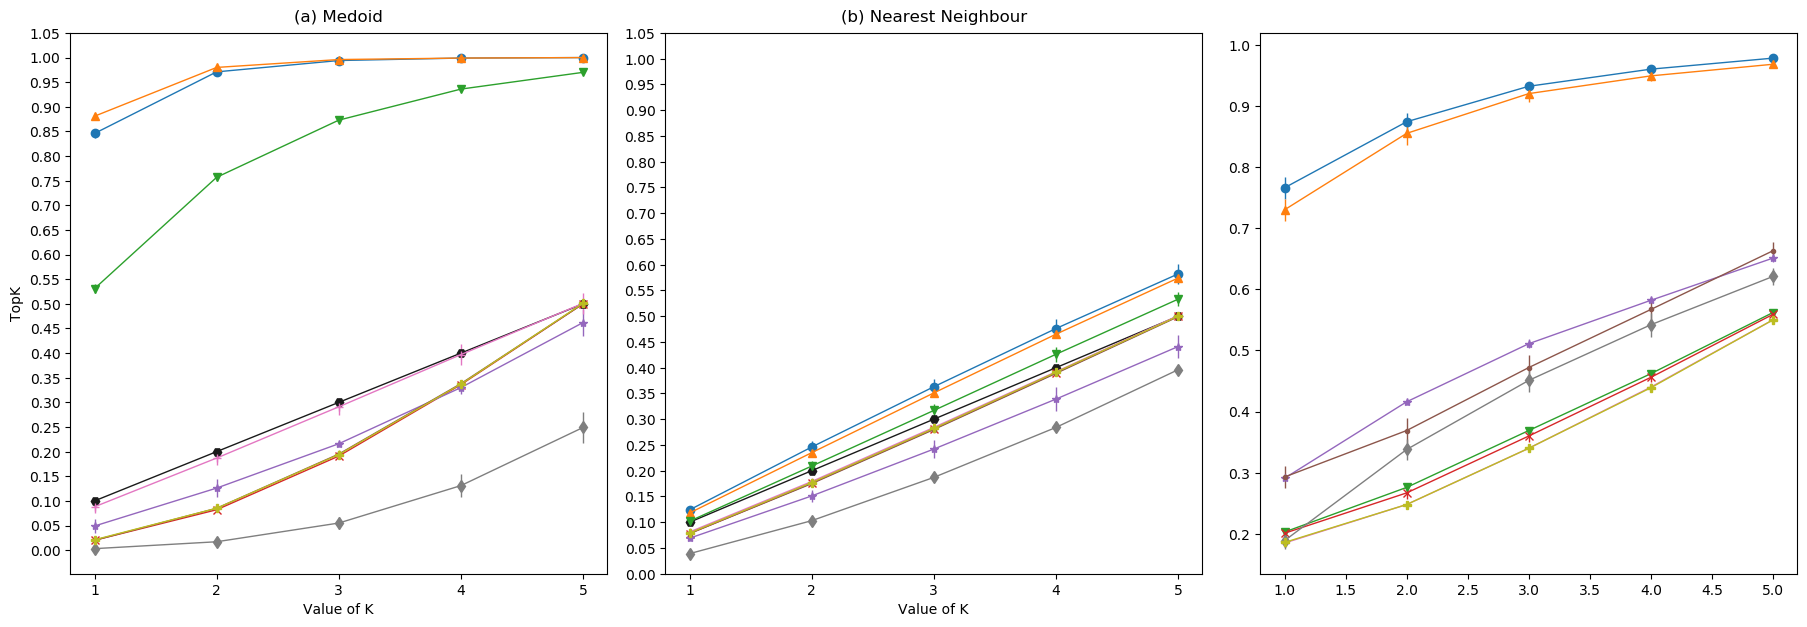

In [10]:
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [12]:
def get_results_for_dataset_2(del_jid = True):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'discrete_choice'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {2} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset = ANY({3}) AND {1}.dataset_params->>\'dataset_type\'= ANY({4})"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, metrics, "\'{synthetic_dc, mnist_dc}\'", "\'{hypervolume, unique, unique_max_occurring}\'")
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'][job['learner']].get("n_hidden", [])
        if job['hp_ranges'][job['learner']].get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3_discrete_choice")
    select_st = select_jobs.format(results_table, avail_jobs, metrics, "\'{synthetic_dc, mnist_dc}\'", "\'{hypervolume, unique, unique_max_occurring}\'")
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    if del_jid:
        del df_full['job_id']
    cols = list(df_full.columns)
    data = []
    dataf = []
    columns = []
    for c in cols:
        if 'categorical' in c:
            columns.append("{}se".format(c))
    columns = cols + columns
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                one_row.extend([m for m in mean])
                one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = "FETA_DC"
            elif "FATE_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = "FATE_DC"
            elif "RANKNET_" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = "RANKNET_DC"
            else:
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    del df['categoricaltopk6se']
    return df

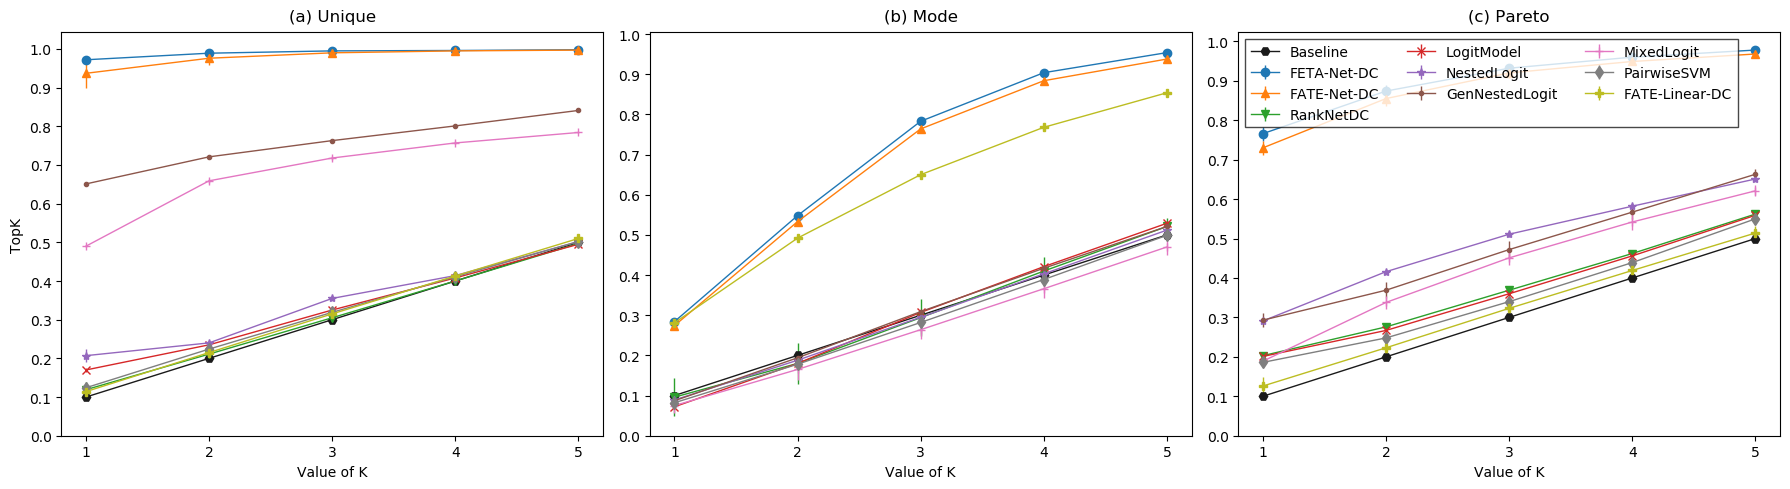

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini, sharey=False, sharex = False, zoom=False):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=sharey, sharex=sharex ,frameon=True, edgecolor='k', facecolor='white')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.subplots_adjust(hspace=0)
    markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P"]
    n_objects = 10
    for i, group in enumerate(grouped):
        zmini = 100
        zmaxi = -100
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
            del group['categoricaltopk5se']
            n_objects = 5
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])/2) + 1
        total = len(N_OBJECTS_ARRAY)
        dataFrame = group.set_index('learner').T
        try:
            if zoom:
                sub_plot, sub_plotz = axs[i][0], axs[i][1]
            else:
                sub_plot = axs[i]
        except Exception:
            if zoom:
                sub_plot, sub_plotz = axs
            else:
                sub_plot = axs
        j = 0
        for learner, model in zip(Dlower,models):
            if learner in list(dataFrame.columns):
                acc_se = dataFrame[learner].as_matrix()[1:]
                acc = acc_se[0:total]
                se = acc_se[total:]
                zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
                sub_plot.errorbar(N_OBJECTS_ARRAY, acc, se, label=model, marker=markers[j], linewidth=1)
                if zoom:
                    sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label=model, marker=markers[j], linewidth=1)
                j = j+1
        
        acc = N_OBJECTS_ARRAY/n_objects
        sub_plot.plot(N_OBJECTS_ARRAY, acc, label='Baseline', linewidth=1, color='k', marker='H')
        #zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
        if i == 0:
            sub_plot.set_ylabel(y_label)
            maxi, mini = get_max_min(maxi, mini, acc)
        sub_plot.set_yticks(np.arange(mini, maxi+0.1, 0.1))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if zoom:
            #sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label='RANDOM', linewidth=1, color='k', marker='H')
            sub_plotz.set_xticks(N_OBJECTS_ARRAY[0:2])
            sub_plotz.set_yticks(np.arange(zmini, zmaxi, 0.1))
            sub_plotz.set_xlabel(x_label)
            title = "{} {}".format("Zoomed in ",get_name(name))
            sub_plotz.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    fig_param['fname'] = plot_file
    plt.savefig(**fig_param)
    plt.tight_layout()
    plt.show()
plot_file = os.path.join(DIR_PATH, "thesis", "dc_results.pdf")
df = get_results_for_dataset_2()
df = df[df['learner']!='PAIRED_COMBINATORIAL_LOGIT']

last = int(len(df.columns[2:])/2)
maxi = 1.0 #np.around(np.max(df.as_matrix()[:,2:last+2]),2)
mini = 0.0 #np.around(np.min(df.as_matrix()[:,2:last+2]),2)
sharex = False
sharey = False
margin=0.05
grouped = df.groupby(['dataset'])
print(grouped)
groups = np.array([group for group in grouped])
groups = groups[[1,2,0]]
a = 1
b = 3
size = (18,5)
cols = 3
plot_group(groups, plot_file, size, cols, a, b, maxi, mini, sharey, sharex, False)

In [14]:
def create_combined_dfs2(DATASET, latex_row=False):
    df_full, columns = get_results_for_dataset(DATASET)
    data = []
    dataf = []
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [get_name(dataset), learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                #one_row.extend([m for m in mean])
                #one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                if latex_row:
                    one_row.extend(["{:.3f}({:.0f})".format(m, s*1e3) for m, s in zip(mean, std)])
                else:
                    one_row.extend(["{:.3f}±{:.3f}".format(m, s) for m, s in zip(mean, std)])
            if "FETA_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = models_dict["FETA_DC"]
            elif "FATE_" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = models_dict["FATE_DC"]
            elif "RANKNET_" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = models_dict["RANKNET_DC"]
            else:
                one_row[1] = models_dict[one_row[1]]
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    if not latex_row:
        for i in range(len(columns)):
            if "categorical" in columns[i]:
                if "accuracy" in columns[i]:
                    columns[i] = "CategoricalAccuracy"
                else:
                    columns[i] = "Top-{}".format(columns[i].split("topk")[-1])
            else:
                columns[i] = columns[i].title()
                if columns[i] == 'Learner':
                    columns[i] = "DCM"
        df = pd.DataFrame(data, columns=columns)
        df.sort_values(by='Dataset')
    else:
        df = pd.DataFrame(data, columns=columns)
        df.sort_values(by='dataset')
    return df

In [15]:
import copy
combined = os.path.join(DIR_PATH, 'detailedresults' , "DiscreteChoice.csv")
dataFrame = None
for dataset in datasets:
    df = create_combined_dfs2(dataset)
    df_path = os.path.join(DIR_PATH, 'detailedresults' , dataset.split('_dc')[0].title()+'DC.csv')
    df.to_csv(df_path, index=False, encoding='utf-8')
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame.to_csv(combined)
dataFrame

,Dataset,DCM,CategoricalAccuracy,Top-2,Top-3,Top-4,Top-5,Top-6
0,Pareto,FATE-Linear-DC,0.126±0.022,0.223±0.016,0.323±0.015,0.419±0.012,0.514±0.019,0.611±0.031
1,Pareto,GenNestedLogit,0.293±0.018,0.369±0.020,0.472±0.021,0.567±0.018,0.663±0.014,0.756±0.009
2,Pareto,MixedLogit,0.189±0.014,0.338±0.017,0.451±0.019,0.542±0.020,0.621±0.014,0.692±0.010
3,Pareto,LogitModel,0.201±0.008,0.267±0.010,0.360±0.010,0.456±0.008,0.559±0.004,0.664±0.004
4,Pareto,NestedLogit,0.291±0.003,0.416±0.005,0.511±0.007,0.582±0.006,0.651±0.006,0.722±0.004
5,Pareto,PairedLogit,0.185±0.001,0.248±0.001,0.340±0.002,0.440±0.002,0.550±0.002,0.668±0.002
6,Pareto,PairwiseSVM,0.186±0.001,0.248±0.001,0.340±0.002,0.439±0.002,0.550±0.002,0.667±0.002
7,Pareto,FETA-Net-DC,0.766±0.018,0.874±0.015,0.932±0.005,0.960±0.002,0.978±0.001,0.990±0.002
8,Pareto,RankNetDC,0.203±0.004,0.276±0.006,0.369±0.006,0.462±0.005,0.562±0.004,0.665±0.007
9,Pareto,FATE-Net-DC,0.730±0.018,0.855±0.019,0.920±0.013,0.949±0.009,0.968±0.006,0.980±0.003


In [ ]:
def plot_graphs_for_dataset(DATASET):
    #plot_file = os.path.join(DIR_PATH, "detailedresults",'graphs', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    plot_file = os.path.join(DIR_PATH, "presentation", "{}{}.png".format(DATASET.split('_dc')[0], '{}'))
    df = create_combined_dfs(DATASET)
    if DATASET == 'synthetic_dc':
        df = df[df['dataset'] != "NEAREST_NEIGHBOUR_MEDOID"]

    grouped = df.groupby(['dataset'])
    last = int(len(df.columns[2:])/2)
    maxi = np.around(np.max(df.as_matrix()[:,2:last+2]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:last+2]),2)
    i = 0
    if len(grouped)in [2, 4]:
        a = 1
        b = 2
        size = (15,6)
    if len(grouped) in [3,6]:
        a = 1
        b = 3
        size = (18,6)
    if len(grouped)==1:
        a = 1
        b = 1
        size = (8,6)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(grouped)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]
    sharex = False
    sharey = False
    margin=0.05
    groups = np.array([group for group in grouped])
    dict_inds = {'synthetic_dc':  [[1,0]], 'mnist_dc': [[0,1], [2,3]], 'tag_genome_dc':[[0,1, 5], [2,3, 4]], 
                 'letor_dc': [[1,3], [0,2]], 'sushi_dc':  [[0]]}
    #inds = 
    zoom = False
    inds = dict_inds[DATASET]
    for i, plot_file in enumerate(plot_files):
        if i == 0:
            cols = 3
        else:
            cols = 3
        #if DATASET =='letor_dc':
            #sharex = True
        #    a = 2
        #    b = 2
        #    size = (15,12)
        #    zoom = True
        if DATASET =='sushi_dc':
            #sharex = True
            a = 1
            b = 2
            size = (15,6)
            zoom = True
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini, sharey, sharex, zoom)

synthetic_dc


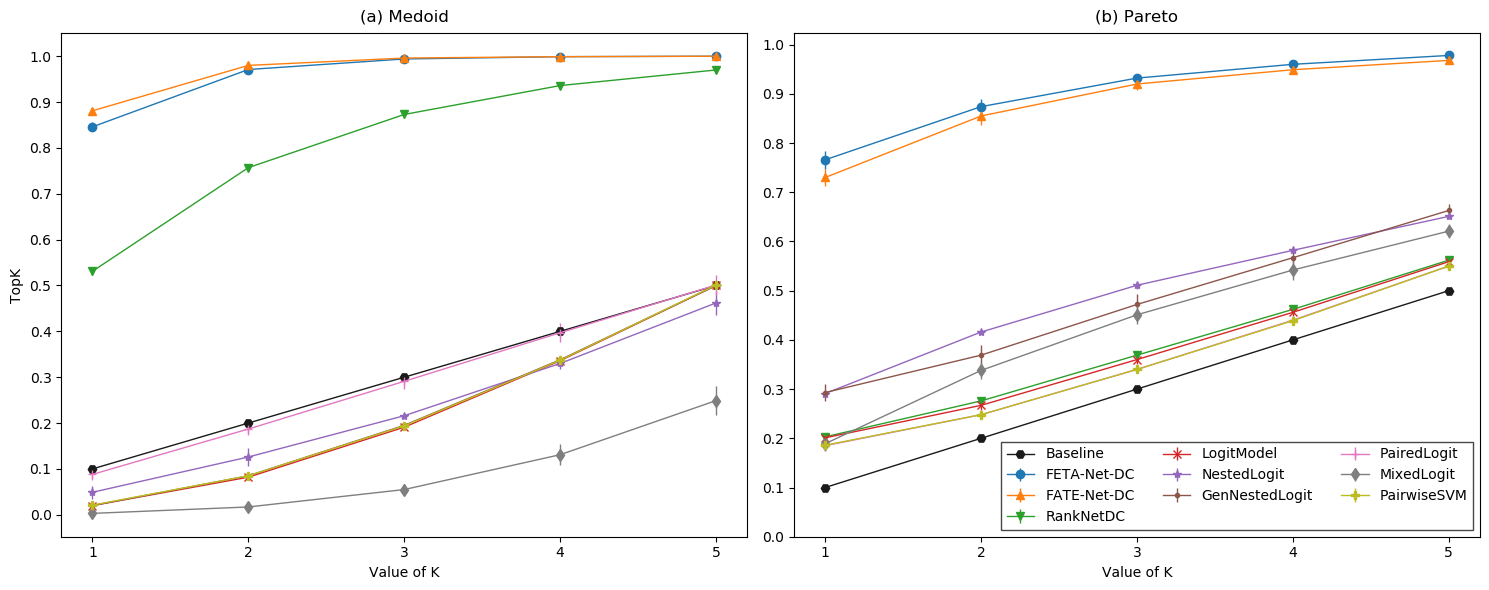

mnist_dc


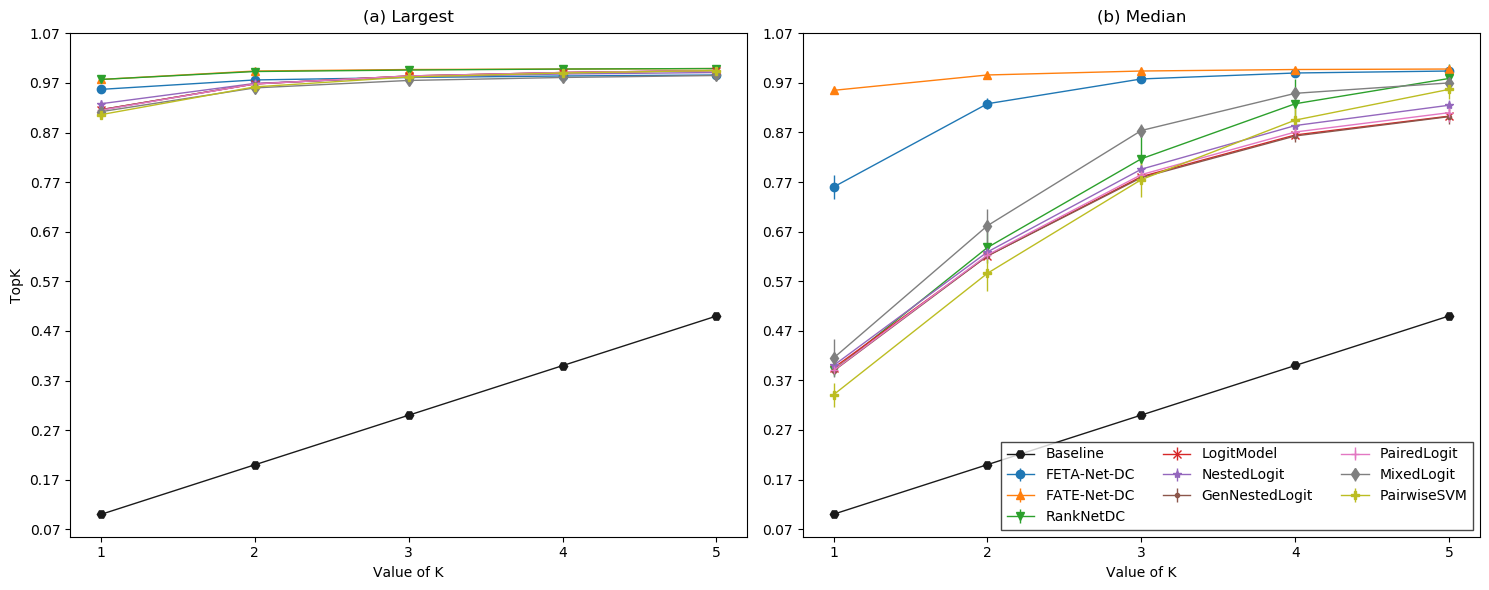

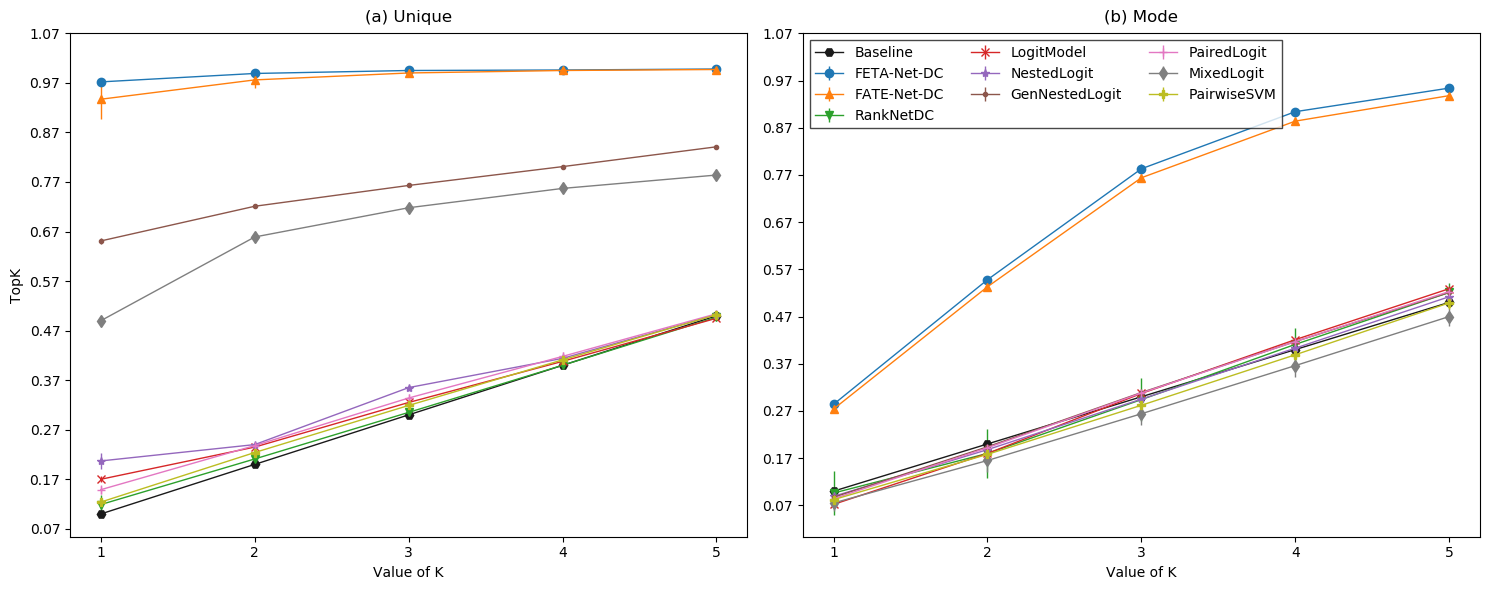

tag_genome_dc


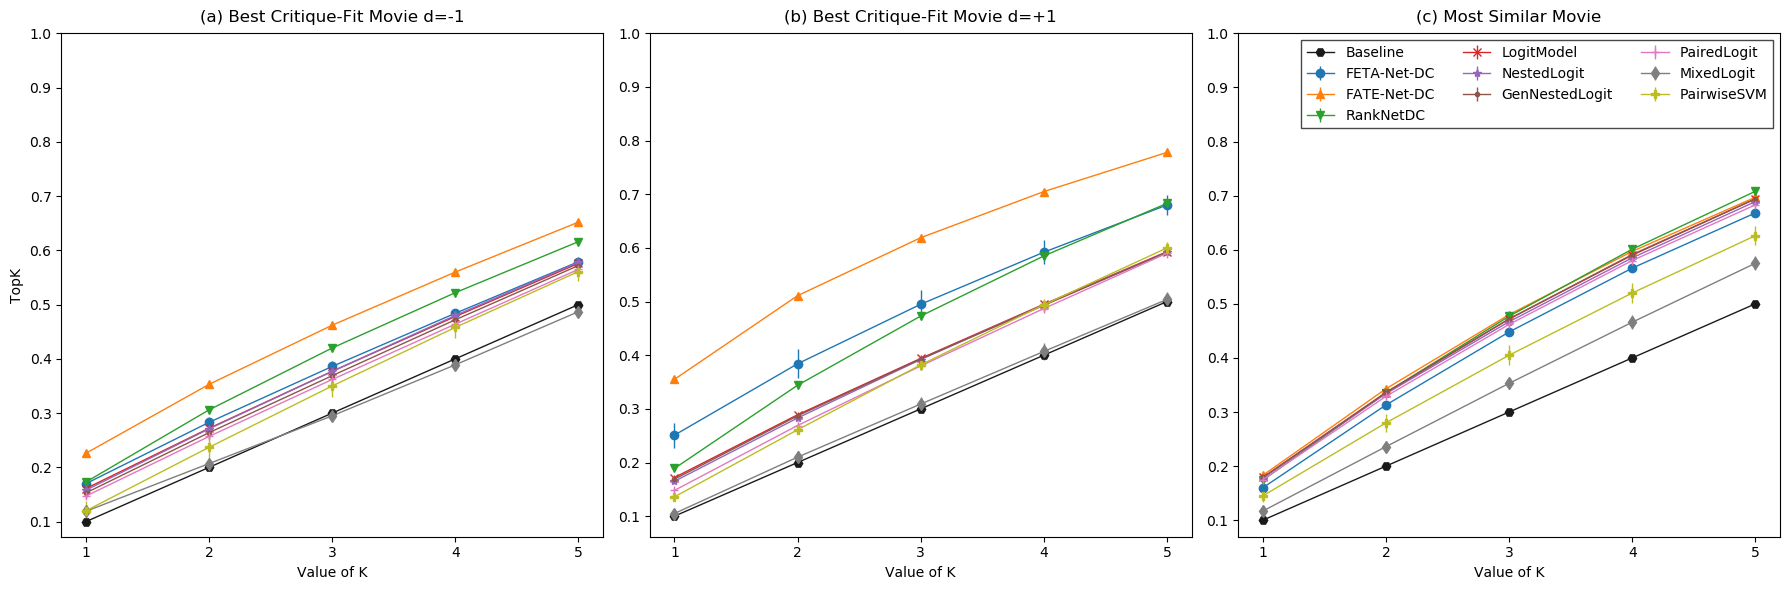

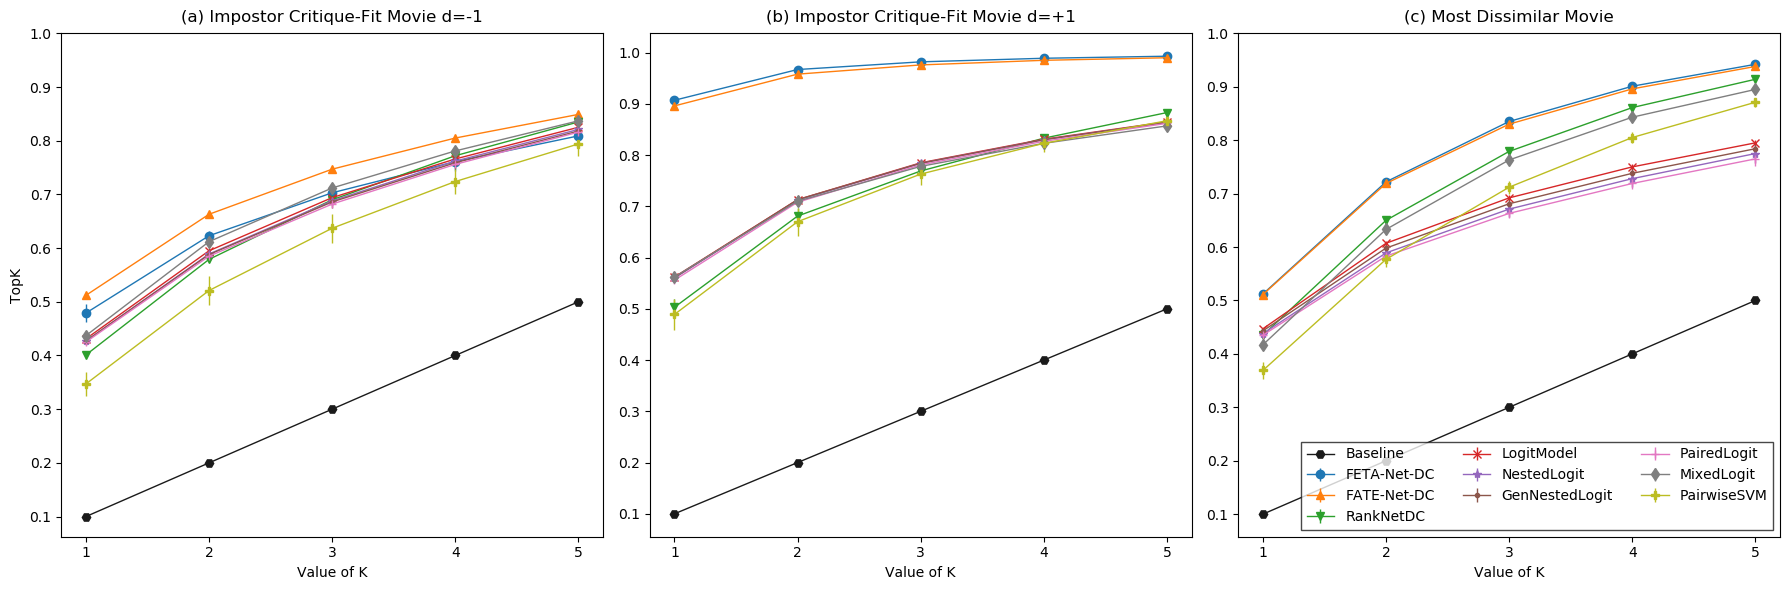

letor_dc


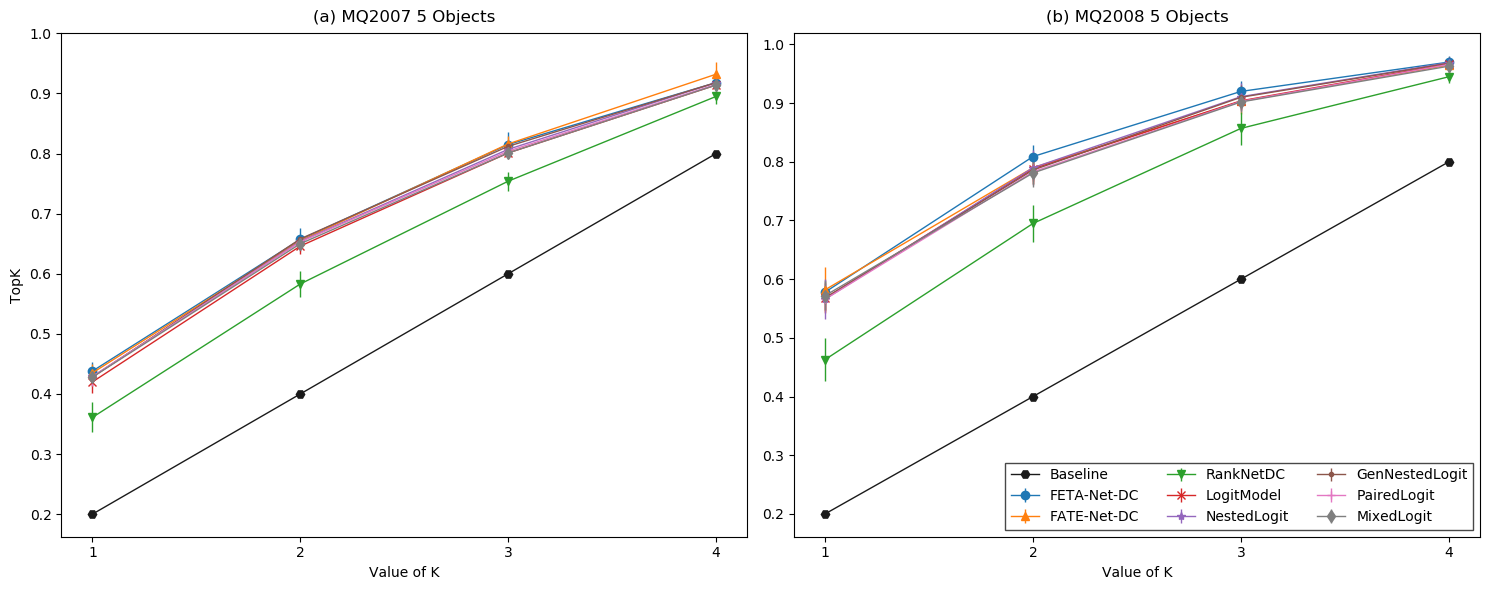

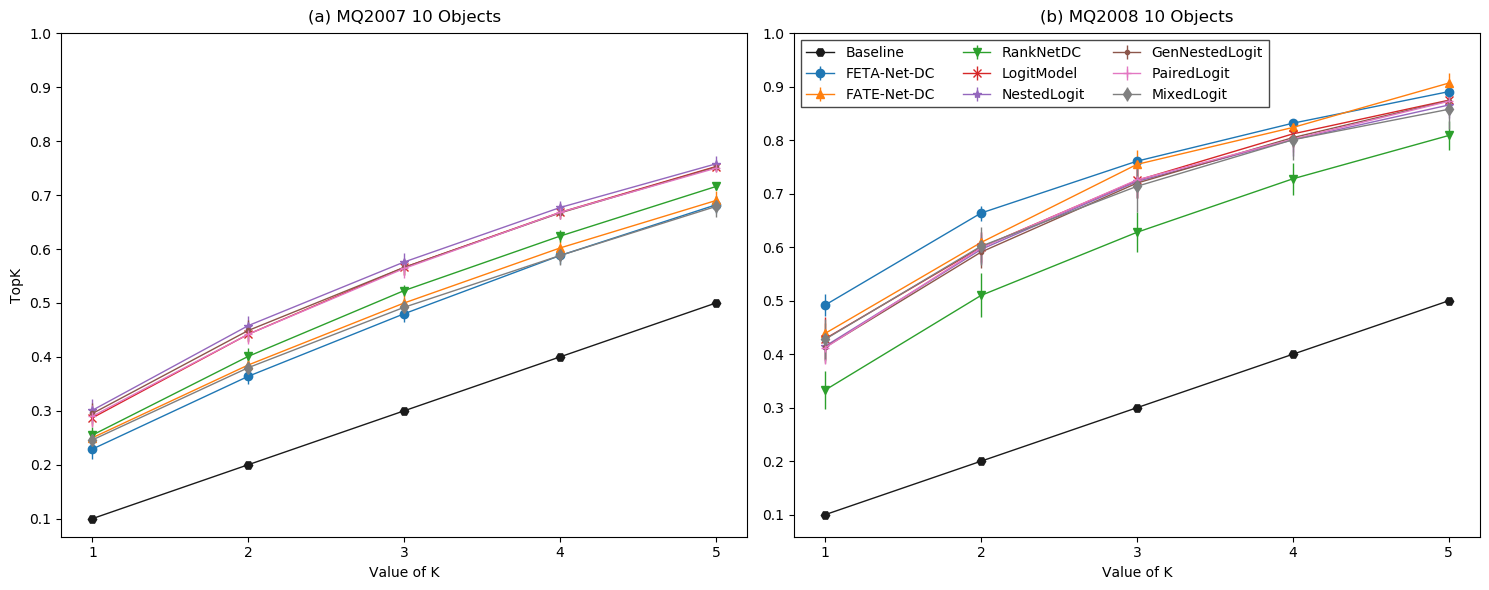

sushi_dc


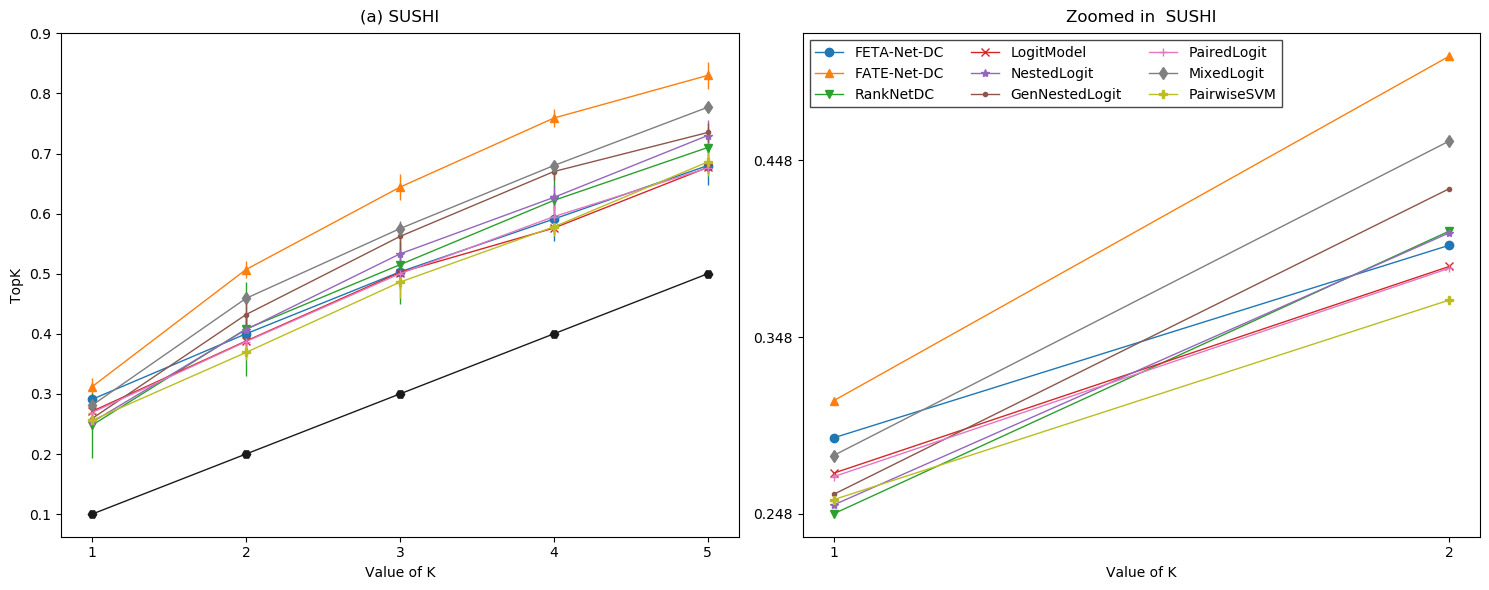

exp_dc


TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'str'

In [16]:
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [30]:
DATASET = datasets[0]
df_full, columns = get_results_for_dataset(DATASET, del_jid=False)
print(columns)
#df_full['zeroonerankaccuracy'] = 1 - df_full['zeroonerankloss']
df = df_full.loc[df_full.learner.str.contains("NESTED_LOGIT_MODEL")].sort_values(['learner', 'dataset'])
#df = df.loc[df.dataset.str.contains("Y_2008")].sort_values(['learner', 'dataset', 'job_id'])
df.head()

['job_id', 'dataset', 'learner', 'categoricalaccuracy', 'categoricaltopk2', 'categoricaltopk3', 'categoricaltopk4', 'categoricaltopk5', 'categoricaltopk6']


,job_id,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
107,1034,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2911,0.4131,0.5085,0.5798,0.6482,0.7191
106,1032,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2915,0.4207,0.5208,0.5917,0.6588,0.7270
105,1006,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2862,0.4090,0.5027,0.5737,0.6437,0.7170
84,1035,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2915,0.4161,0.5100,0.5814,0.6529,0.7258
83,1033,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2955,0.4199,0.5129,0.5819,0.6501,0.7223


In [17]:
df = create_combined_dfs2(datasets[-2], latex_row=True)
df.sort_values(by='dataset')
df

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
0,SUSHI,GenNestedLogit,0.259(7),0.432(24),0.562(23),0.670(14),0.735(16),0.796(13)
1,SUSHI,MixedLogit,0.281(4),0.459(6),0.575(13),0.680(3),0.777(7),0.862(4)
2,SUSHI,LogitModel,0.271(5),0.388(4),0.502(3),0.576(10),0.677(10),0.788(7)
3,SUSHI,NestedLogit,0.253(6),0.407(26),0.533(19),0.627(21),0.730(25),0.776(24)
4,SUSHI,PairedLogit,0.269(6),0.387(6),0.500(12),0.595(18),0.676(10),0.785(6)
5,SUSHI,PairwiseSVM,0.256(7),0.369(12),0.486(26),0.578(16),0.686(24),0.781(7)
6,SUSHI,FETA-Net-DC,0.291(8),0.400(26),0.503(29),0.591(37),0.680(32),0.758(28)
7,SUSHI,RankNetDC,0.248(54),0.408(79),0.515(65),0.622(50),0.710(33),0.768(22)
8,SUSHI,FATE-Net-DC,0.312(15),0.507(14),0.644(22),0.759(15),0.830(22),0.918(16)


In [18]:
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    return [vals[0], vals[0] - vals[1]*1e-3]
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[['learner',col]].as_matrix()
        values = np.array([get_val(val[1])for val in values_str])
        maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df['learner'] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [19]:
import re
import string
grouped = df.groupby(['dataset'])
for name, group in grouped:
    
    custom_dict = {"PairwiseSVM":0, "RankNetDC":1, 'LogitModel':2, 'NestedLogit':3, 'GenNestedLogit':4, 
                   'PairedLogit':5, "GenNestedLogit":6, "MixedLogit":7, "FATE-Net-DC":8, "FETA-Net-DC":9}
    group['rank'] = group['learner'].map(custom_dict)
    group.sort_values(by='rank', inplace=True)
    del group["dataset"]
    del group['rank']
    group = mark_best(group)
    if len(group)==9:
        group['learner'] = ["pairwisesvm", "ranknetdc", "mnl", "nlm", "gnl", "pcl", "mlm", "fatedc", "fetadc"]
    print("name {}".format(name))
    group = group.drop(columns='categoricaltopk6')
    if "N_5" in name:
        group = group.drop(columns='categoricaltopk5')
    latex_code = group.to_latex(index = False)
    latex_code = latex_code.replace(' ',"")
    latex_code = latex_code.replace('&'," & ")
    latex_code = str(latex_code)
    for learner in group['learner']:
        latex_code = latex_code.replace(learner, "\\{}".format(learner))
    latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
    #latex_code = latex_code.replace("0.", ".")

    print(latex_code)
#df.T.to_latex()

name SUSHI
\begin{tabular}{llllll}
\toprule
learner & categoricalaccuracy & categoricaltopk2 & categoricaltopk3 & categoricaltopk4 & categoricaltopk5\\
\midrule
\pairwisesvm & 0.256(7) & 0.369(12) & 0.486(26) & 0.578(16) & 0.686(24)\\
\ranknetdc & 0.248(54) & 0.408(79) & 0.515(65) & 0.622(50) & 0.710(33)\\
\mnl & 0.271(5) & 0.388(4) & 0.502(3) & 0.576(10) & 0.677(10)\\
\nlm & 0.253(6) & 0.407(26) & 0.533(19) & 0.627(21) & 0.730(25)\\
\gnl & 0.269(6) & 0.387(6) & 0.500(12) & 0.595(18) & 0.676(10)\\
\pcl & 0.259(7) & 0.432(24) & 0.562(23) & 0.670(14) & 0.735(16)\\
\mlm & 0.281(4) & 0.459(6) & 0.575(13) & 0.680(3) & 0.777(7)\\
\fatedc & \bfseries 0.312(15) & \bfseries 0.507(14) & \bfseries 0.644(22) & \bfseries 0.759(15) & \bfseries 0.830(22)\\
\fetadc & 0.291(8) & 0.400(26) & 0.503(29) & 0.591(37) & 0.680(32)\\
\bottomrule
\end{tabular}



In [33]:
import re
def remove_ranker(sub_df):
    remove_ranker = None
    if len(sub_df)==2:
        sub_df = sub_df[:,1:3]
        val1 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[0][1])]
        val2 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[1][1])]
        val1 = val1[0] if len(val1)==1 else val1[0] - val1[1]*1e-3
        val2 = val2[0] if len(val2)==1 else val2[0] - val2[1]*1e-3
        if val1 < val2 :
            remove_ranker = sub_df[0][0]
        else:
            remove_ranker = sub_df[1][0]
    
    return remove_ranker

In [ ]:
"UNIQUE_MAX_OCCURRING".lower()